# Insurance Fraud Dection using Gradient Boosted Trees

1. Show data cleaning and preparation steps

2. Perform EDA on the given dataset and list out findings ( performed on previous report on week 3)

3. Predict the fraud projection with gradient boosted tree algorithms - Use accuracy as metrics and provide best possible accuracy.

4. Feature ranking based on the tree algorithm to get better of factors contributing to the fraud detection
*italicized text*



# Gradient Boosted Trees Modeling

## Load the fraud dataset
You will be using the titanic dataset, where the (rather morbid) goal is to predict passenger survival, given characteristics such as gender, age, class, etc.

In [0]:
import numpy as np
import pandas as pd
from IPython.display import clear_output



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load dataset.
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/Week9/insurance_claims.csv')


In [0]:
data_Fraud = data[data['fraud_reported']=='Y']
data_NonFraud =  data[data['fraud_reported']=='N']

In [0]:
data['fraud_reported'].value_counts()

N    753
Y    247
Name: fraud_reported, dtype: int64

In [0]:
df_fraud_example = pd.concat([data_Fraud, data_Fraud, data_Fraud], axis = 0)
data_balanced = pd.concat([data_NonFraud, df_fraud_example], axis = 0)
data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)

In [0]:
data_balanced.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,147,37,952300,2009-08-02,OH,500/1000,1000,1439.90,6000000,475391,FEMALE,Associate,prof-specialty,video-games,husband,0,-48400,2015-01-29,Multi-vehicle Collision,Rear Collision,Total Loss,Other,SC,Springfield,4931 Maple Drive,2,2,NO,1,2,NO,53680,9760,4880,39040,Accura,MDX,2004,N,NaN
1,111,27,532330,2002-09-22,OH,250/500,500,1459.97,5000000,441783,MALE,MD,sales,yachting,other-relative,0,0,2015-02-27,Multi-vehicle Collision,Side Collision,Major Damage,Police,SC,Northbend,4983 MLK Ridge,2,3,NO,1,2,NO,80850,7350,14700,58800,Ford,F150,2011,Y,NaN
2,35,35,930032,2002-09-10,IL,100/300,2000,1117.42,0,446158,FEMALE,PhD,protective-serv,kayaking,not-in-family,0,-51900,2015-02-14,Multi-vehicle Collision,Side Collision,Minor Damage,Fire,NC,Hillsdale,7909 Andromedia Hwy,23,3,NO,2,2,NO,53190,5910,11820,35460,Volkswagen,Jetta,1996,N,NaN
3,261,46,156636,2000-09-10,IN,100/300,1000,870.55,0,465631,MALE,PhD,prof-specialty,camping,unmarried,0,-49400,2015-01-27,Single Vehicle Collision,Rear Collision,Minor Damage,Other,SC,Springfield,1532 Washington St,19,1,?,0,3,?,80280,13380,13380,53520,Chevrolet,Tahoe,2013,N,NaN
4,239,39,730819,1990-08-18,IN,250/500,2000,625.08,0,437156,FEMALE,JD,protective-serv,hiking,wife,44200,-37000,2015-01-03,Single Vehicle Collision,Front Collision,Major Damage,Fire,SC,Riverwood,2757 4th Hwy,10,1,NO,2,3,YES,87890,15980,7990,63920,BMW,X6,2014,Y,NaN


In [0]:
data_balanced['fraud_reported'] = np.where(data_balanced['fraud_reported']=='Y', 1, 0)
#dfeval['fraud_reported'] = np.where(dfeval['fraud_reported']=='Y', 1, 0)

In [0]:
#y_train = dftrain.pop('fraud_reported')
#y_eval = dfeval.pop('fraud_reported')

In [0]:
data_balanced['insured_sex'] = np.where(data_balanced['insured_sex']=='MALE', 1, 0)
#dfeval['insured_sex'] = np.where(dfeval['insured_sex']=='MALE', 1, 0)


In [0]:
data_balanced['incident_date'] = pd.to_datetime(data_balanced['incident_date'])
data_balanced['policy_bind_date'] = pd.to_datetime(data_balanced['policy_bind_date'])

data_balanced['accd_month_since'] = round(pd.to_numeric((data_balanced['incident_date']  - data_balanced['policy_bind_date']) / np.timedelta64(1, 'M')))

In [0]:
data_balanced.drop(columns = ['policy_number', 'policy_bind_date', 'incident_date', 'incident_location', 'insured_zip', '_c39'], axis = 1, inplace=True)
#dfeval.drop(columns = ['policy_number', 'policy_bind_date', 'incident_date', 'incident_location', 'insured_zip', '_c39'], axis = 1, inplace=True)

In [0]:
#selectedcolumns = ['months_as_customer', 'age','accd_month_since', 'insured_sex']
num_columns = ['months_as_customer', 'age','accd_month_since', 'capital-gains','capital-loss', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim','auto_year']
cat_columns = [ 'policy_state', 'policy_csl','insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship','insured_sex',
                       'incident_type', 'collision_type', 'incident_severity','authorities_contacted', 'incident_state', 'incident_city', 'property_damage', 
                       'police_report_available', 'auto_make']
selectedcolumns = num_columns + cat_columns

In [0]:
data_balanced.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,accd_month_since
0,147,37,OH,500/1000,1000,1439.90,6000000,0,Associate,prof-specialty,video-games,husband,0,-48400,Multi-vehicle Collision,Rear Collision,Total Loss,Other,SC,Springfield,2,2,NO,1,2,NO,53680,9760,4880,39040,Accura,MDX,2004,0,66.0
1,111,27,OH,250/500,500,1459.97,5000000,1,MD,sales,yachting,other-relative,0,0,Multi-vehicle Collision,Side Collision,Major Damage,Police,SC,Northbend,2,3,NO,1,2,NO,80850,7350,14700,58800,Ford,F150,2011,1,149.0
2,35,35,IL,100/300,2000,1117.42,0,0,PhD,protective-serv,kayaking,not-in-family,0,-51900,Multi-vehicle Collision,Side Collision,Minor Damage,Fire,NC,Hillsdale,23,3,NO,2,2,NO,53190,5910,11820,35460,Volkswagen,Jetta,1996,0,149.0
3,261,46,IN,100/300,1000,870.55,0,1,PhD,prof-specialty,camping,unmarried,0,-49400,Single Vehicle Collision,Rear Collision,Minor Damage,Other,SC,Springfield,19,1,?,0,3,?,80280,13380,13380,53520,Chevrolet,Tahoe,2013,0,173.0
4,239,39,IN,250/500,2000,625.08,0,0,JD,protective-serv,hiking,wife,44200,-37000,Single Vehicle Collision,Front Collision,Major Damage,Fire,SC,Riverwood,10,1,NO,2,3,YES,87890,15980,7990,63920,BMW,X6,2014,1,293.0


In [0]:
print(len(data_balanced.columns))

35


In [0]:

dftrain =data_balanced.iloc[:1200, :]
dfeval = data_balanced.iloc[1200:,:]
y_train = dftrain.pop('fraud_reported')
y_eval = dfeval.pop('fraud_reported')

In [0]:
dftrain = dftrain[selectedcolumns]
dfeval = dfeval[selectedcolumns]

In [0]:
import tensorflow as tf
tf.random.set_seed(123)

In [0]:
dftrain.head()

,months_as_customer,age,accd_month_since,capital-gains,capital-loss,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,policy_state,policy_csl,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,insured_sex,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,property_damage,police_report_available,auto_make
0,147,37,66.0,0,-48400,53680,9760,4880,39040,2004,OH,500/1000,Associate,prof-specialty,video-games,husband,0,Multi-vehicle Collision,Rear Collision,Total Loss,Other,SC,Springfield,NO,NO,Accura
1,111,27,149.0,0,0,80850,7350,14700,58800,2011,OH,250/500,MD,sales,yachting,other-relative,1,Multi-vehicle Collision,Side Collision,Major Damage,Police,SC,Northbend,NO,NO,Ford
2,35,35,149.0,0,-51900,53190,5910,11820,35460,1996,IL,100/300,PhD,protective-serv,kayaking,not-in-family,0,Multi-vehicle Collision,Side Collision,Minor Damage,Fire,NC,Hillsdale,NO,NO,Volkswagen
3,261,46,173.0,0,-49400,80280,13380,13380,53520,2013,IN,100/300,PhD,prof-specialty,camping,unmarried,1,Single Vehicle Collision,Rear Collision,Minor Damage,Other,SC,Springfield,?,?,Chevrolet
4,239,39,293.0,44200,-37000,87890,15980,7990,63920,2014,IN,250/500,JD,protective-serv,hiking,wife,0,Single Vehicle Collision,Front Collision,Major Damage,Fire,SC,Riverwood,NO,YES,BMW


In [0]:
dfeval.head(
    
)

,months_as_customer,age,accd_month_since,capital-gains,capital-loss,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,policy_state,policy_csl,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,insured_sex,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,property_damage,police_report_available,auto_make
1200,127,31,150.0,58200,0,6160,560,1120,4480,1996,OH,500/1000,Associate,sales,reading,not-in-family,1,Parked Car,?,Minor Damage,None,SC,Riverwood,YES,NO,Nissan
1201,135,30,72.0,37100,-46500,32670,5940,2970,23760,2003,IN,500/1000,MD,farming-fishing,skydiving,wife,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Ambulance,WV,Riverwood,NO,NO,Honda
1202,84,32,167.0,0,0,57240,4770,9540,42930,1995,IL,500/1000,Associate,prof-specialty,cross-fit,husband,0,Single Vehicle Collision,Rear Collision,Total Loss,Other,NY,Northbend,YES,?,BMW
1203,14,28,151.0,0,-26900,71280,12960,12960,45360,2012,OH,250/500,Associate,craft-repair,board-games,unmarried,0,Single Vehicle Collision,Rear Collision,Major Damage,Fire,WV,Riverwood,?,YES,Audi
1204,61,29,238.0,0,-66000,5900,590,590,4720,2010,IN,250/500,JD,handlers-cleaners,polo,unmarried,1,Parked Car,?,Trivial Damage,None,VA,Hillsdale,YES,YES,Nissan


For a description of the features, please review the prior tutorial.

## Create feature columns, input_fn, and the train the estimator

### Preprocess the data

Create the feature columns, using the original numeric columns as is and one-hot-encoding categorical variables.

In [0]:
fc = tf.feature_column
CATEGORICAL_COLUMNS =[ 'policy_state', 'policy_csl','insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship','insured_sex',
               'incident_type', 'collision_type', 'incident_severity','authorities_contacted', 'incident_state', 'incident_city', 'property_damage', 
                       'police_report_available', 'auto_make']
NUMERIC_COLUMNS = ['months_as_customer', 'age','accd_month_since',  'capital-gains','capital-loss', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim','auto_year']#['months_as_customer', 'age', 'accd_month_since']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

### Build the input pipeline

Create the input functions using the `from_tensor_slices` method in the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API to read in data directly from Pandas.

In [0]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

### Train the model

In [0]:
params = {
  'n_trees': 100,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.846939
accuracy_baseline,0.503401
auc,0.889694
auc_precision_recall,0.857873
average_loss,0.404094
label/mean,0.503401
loss,0.404094
precision,0.836601
prediction/mean,0.497031
recall,0.864865


In [0]:
type(results)

dict

For performance reasons, when your data fits in memory, we recommend use the `boosted_trees_classifier_train_in_memory` function. However if training time is not of a concern or if you have a very large dataset and want to do distributed training, use the `tf.estimator.BoostedTrees` API shown above.


When using this method, you should not batch your input data, as the method operates on the entire dataset.


In [0]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# Train the model.
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
clear_output()
print(est.evaluate(eval_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-17T15:56:54Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxnynrhaq/model.ckpt-152
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.82568s
INFO:tensorflow:Finished evaluation at 2020-04-17-15:56:55
INFO:tensorflow:Saving dict for global step 152: accuracy = 0.85374147, accuracy_baseline = 0.50340134, auc = 0.90327656, auc_precision_recall = 0.859241, average_loss = 0.3729212, global_step = 152, label/mean = 0.50340134, loss = 0.3729212, precision = 0.82608694, prediction/mean = 0.4993243, recall = 0.8986486
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 152: /tmp

In [0]:
# iterate on the tree numbers and get the optimzed tree numbers
accuracy_all = []
treeNums =[]
All_results = pd.DataFrame()
for i in range(10):
    params = {
    'n_trees': (i+1)*20,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    # You must enable center_bias = True to get DFCs. This will force the model to
    # make an initial prediction before using any features (e.g. use the mean of
    # the training labels for regression or log odds for classification when
    # using cross entropy loss).
    'center_bias': True
    }

    est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
    # Train model.
    est.train(train_input_fn, max_steps=100)

    # Evaluation.
    results = est.evaluate(eval_input_fn)
    treeNums.append((i+1)*20)
    clear_output()

    All_results = pd.concat([All_results,pd.Series(results).to_frame()], axis =1)


In [0]:
All_results_NewName = pd.DataFrame(data=All_results.values, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], index = All_results.index)

In [0]:
All_results_NewName

,1,2,3,4,5,6,7,8,9,10
accuracy,0.836735,0.850340,0.850340,0.850340,0.836735,0.843537,0.850340,0.840136,0.843537,0.843537
accuracy_baseline,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401
auc,0.881896,0.893535,0.891151,0.900939,0.897145,0.895108,0.894437,0.889717,0.895687,0.891499
auc_precision_recall,0.843640,0.876675,0.864873,0.891395,0.861002,0.875855,0.871487,0.872481,0.843111,0.861024
average_loss,0.413320,0.400965,0.397818,0.389069,0.394572,0.399367,0.395677,0.402797,0.397676,0.401927
label/mean,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401
loss,0.413320,0.400965,0.397818,0.389069,0.394572,0.399367,0.395677,0.402797,0.397676,0.401927
precision,0.824675,0.842105,0.842105,0.842105,0.824675,0.831169,0.842105,0.825806,0.835526,0.831169
prediction/mean,0.507838,0.492855,0.498711,0.492833,0.504140,0.498424,0.490930,0.507323,0.503972,0.496509
recall,0.858108,0.864865,0.864865,0.864865,0.858108,0.864865,0.864865,0.864865,0.858108,0.864865


{'boxes': [<matplotlib.lines.Line2D at 0x7f9e72b6e160>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9e7659ce80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9e73399630>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9e73399d68>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9e7659c668>,
  <matplotlib.lines.Line2D at 0x7f9e7659cd30>]}

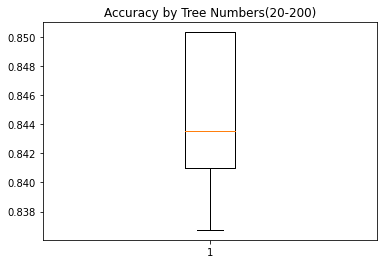

In [0]:

import matplotlib.pyplot as plt
plt.title("Accuracy by Tree Numbers(20-200)")
plt.boxplot( All_results_NewName.loc['accuracy', :].values)


In [0]:
# get the parameters and optimize on max_depth of tree

accuracy_all = []
maxDepths =[]
All_results = pd.DataFrame()
for i in range(10):
    params = {
    'n_trees': 80,
    'max_depth': (i+2),
    'n_batches_per_layer': 1,
    # You must enable center_bias = True to get DFCs. This will force the model to
    # make an initial prediction before using any features (e.g. use the mean of
    # the training labels for regression or log odds for classification when
    # using cross entropy loss).
    'center_bias': True
    }

    est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
    # Train model.
    est.train(train_input_fn, max_steps=100)

    # Evaluation.
    results = est.evaluate(eval_input_fn)
    treeNums.append((i+1)*20)
    clear_output()

    All_results = pd.concat([All_results,pd.Series(results).to_frame()], axis =1)

In [0]:
All_results

,0,0,0,0,0,0,0,0,0,0
accuracy,0.840136,0.846939,0.850340,0.857143,0.874150,0.904762,0.914966,0.914966,0.908163,0.908163
accuracy_baseline,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401
auc,0.854915,0.888236,0.914569,0.926578,0.936574,0.941526,0.948584,0.955040,0.960894,0.963393
auc_precision_recall,0.832699,0.875507,0.886298,0.904617,0.921169,0.912664,0.937099,0.946435,0.949397,0.961654
average_loss,0.441851,0.400798,0.369709,0.343751,0.322277,0.297414,0.274412,0.276109,0.287280,0.283489
label/mean,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401
loss,0.441851,0.400798,0.369709,0.343751,0.322277,0.297414,0.274412,0.276109,0.287280,0.283489
precision,0.825806,0.836601,0.842105,0.848684,0.849057,0.861446,0.868263,0.868263,0.857988,0.857988
prediction/mean,0.479964,0.495161,0.511350,0.481859,0.531497,0.547451,0.548523,0.557503,0.568792,0.567149
recall,0.864865,0.864865,0.864865,0.871622,0.912162,0.966216,0.979730,0.979730,0.979730,0.979730


In [0]:
All_results_NewName = pd.DataFrame(data=All_results.values, columns = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], index = All_results.index)

In [0]:
All_results_NewName

,2,3,4,5,6,7,8,9,10,11
accuracy,0.840136,0.846939,0.850340,0.857143,0.874150,0.904762,0.914966,0.914966,0.908163,0.908163
accuracy_baseline,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401
auc,0.854915,0.888236,0.914569,0.926578,0.936574,0.941526,0.948584,0.955040,0.960894,0.963393
auc_precision_recall,0.832699,0.875507,0.886298,0.904617,0.921169,0.912664,0.937099,0.946435,0.949397,0.961654
average_loss,0.441851,0.400798,0.369709,0.343751,0.322277,0.297414,0.274412,0.276109,0.287280,0.283489
label/mean,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401,0.503401
loss,0.441851,0.400798,0.369709,0.343751,0.322277,0.297414,0.274412,0.276109,0.287280,0.283489
precision,0.825806,0.836601,0.842105,0.848684,0.849057,0.861446,0.868263,0.868263,0.857988,0.857988
prediction/mean,0.479964,0.495161,0.511350,0.481859,0.531497,0.547451,0.548523,0.557503,0.568792,0.567149
recall,0.864865,0.864865,0.864865,0.871622,0.912162,0.966216,0.979730,0.979730,0.979730,0.979730


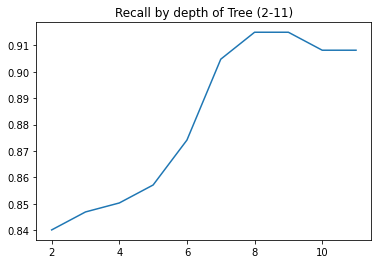

In [0]:
import matplotlib.pyplot as plt
plt.title("Recall by depth of Tree (2-11)")
plt.plot(np.linspace(2,11,num=10), All_results_NewName.loc['accuracy', :].values)

## Model interpretation and plotting

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

## Local interpretability
Next you will output the directional feature contributions (DFCs) to explain individual predictions using the approach outlined in [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) and by Saabas in [Interpreting Random Forests](http://blog.datadive.net/interpreting-random-forests/) (this method is also available in scikit-learn for Random Forests in the [`treeinterpreter`](https://github.com/andosa/treeinterpreter) package). The DFCs are generated with:

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

(Note: The method is named experimental as we may modify the API before dropping the experimental prefix.)

In [0]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpe37kz10f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

In [0]:
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
insured_hobbies,294.0,-0.041725,0.205178,-0.293039,-0.252326,0.068964,0.115749,0.332397
incident_severity,294.0,0.032405,0.142818,-0.110293,-0.091193,-0.088284,0.178232,0.236317
capital-loss,294.0,-0.023293,0.095694,-0.327870,-0.045981,-0.018563,0.040458,0.133292
capital-gains,294.0,-0.001446,0.011683,-0.034046,-0.005579,0.001858,0.002811,0.045065
vehicle_claim,294.0,0.004565,0.011449,-0.029990,0.000229,0.006453,0.011139,0.051963
policy_csl,294.0,-0.001104,0.007324,-0.023716,-0.000731,0.000000,0.001044,0.017324
collision_type,294.0,0.000811,0.007744,-0.035729,-0.002361,-0.001632,0.007695,0.020518
months_as_customer,294.0,0.002189,0.013203,-0.078952,-0.003192,0.004024,0.009007,0.037094
age,294.0,0.001577,0.012915,-0.005204,0.000545,0.000812,0.002319,0.202487
accd_month_since,294.0,-0.001132,0.018840,-0.063817,-0.004103,-0.001650,0.000691,0.136797


A nice property of DFCs is that the sum of the contributions + the bias is equal to the prediction for a given example.

In [0]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

Plot DFCs for an individual passenger. Let's make the plot nice by color coding based on the contributions' directionality and add the feature values on figure.

In [0]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

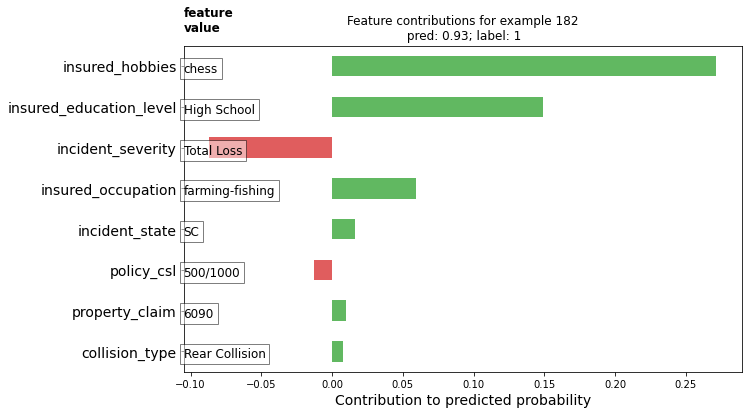

In [0]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

The larger magnitude contributions have a larger impact on the model's prediction. Negative contributions indicate the feature value for this given example reduced the model's prediction, while positive values contribute an increase in the prediction.

You can also plot the example's DFCs compare with the entire distribution using a voilin plot.

In [0]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')

  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

Plot this example.

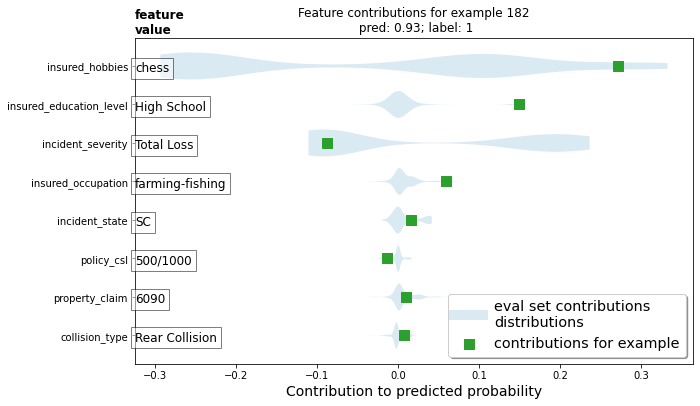

In [0]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

Finally, third-party tools, such as [LIME](https://github.com/marcotcr/lime) and [shap](https://github.com/slundberg/shap), can also help understand individual predictions for a model.

## Global feature importances

Additionally, you might want to understand the model as a whole, rather than studying individual predictions. Below, you will compute and use:

* Gain-based feature importances using `est.experimental_feature_importances`
* Permutation importances
* Aggregate DFCs using `est.experimental_predict_with_explanations`

Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated ([source](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307)). Check out [this article](http://explained.ai/rf-importance/index.html) for an in-depth overview and great discussion on different feature importance types.

### Gain-based feature importances

Gain-based feature importances are built into the TensorFlow Boosted Trees estimators using `est.experimental_feature_importances`.

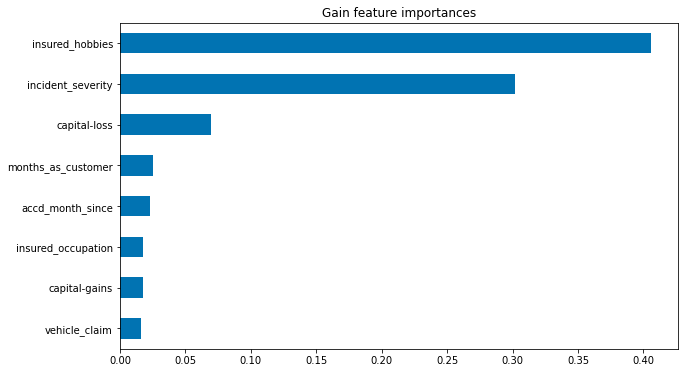

In [0]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

### Average absolute DFCs
You can also average the absolute values of DFCs to understand impact at a global level.

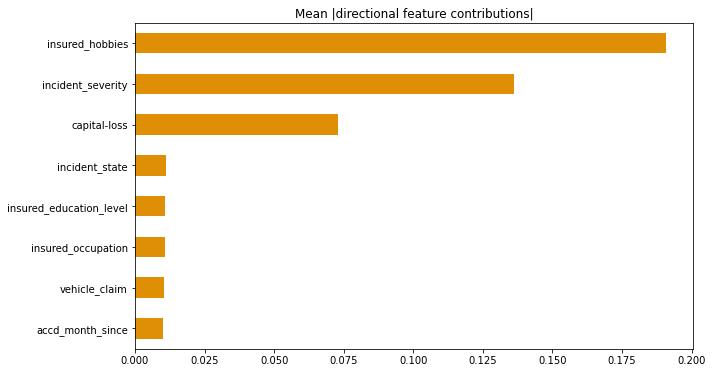

In [0]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

## Conclusion

In this notebook, we showed how to use Boosted Trees models for fraud detection. We also showed analysis using directional feature contributions and feature importance techniques. These techniques provide insight into how the features impact fraud detection model's predictions. We also showed optimzed on tree numbers and detpth of trees. Overall, we achieved accuray of 91% with high recall of 97%.